In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [1]:
# loading the digits data set.
digits = load_digits()

print("TEST--- YES this is working")

print ("We have", digits.data.shape[0], "data points in total.")
print ("Each data point has", digits.data.shape[1], "features. In fact, each instance is an 8x8 picture of a digit.")
print ("Each digit's target/class/label is one of", list(set(digits.target)))

# We want to turn the problem into a binary classification one.
# Therefore, from the data set, we only pick those digits whose label is either 0 or 1
X = digits.data[(digits.target==0)|(digits.target==1)]
Y = digits.target[(digits.target==0)|(digits.target==1)]

print(X[0])
print(Y[0])
print(len(Y))
print ("The reamining number of data points is", X.shape[0])

NameError: name 'load_digits' is not defined

Hear are some of the original digits (first three rows)...and then their noisy versions


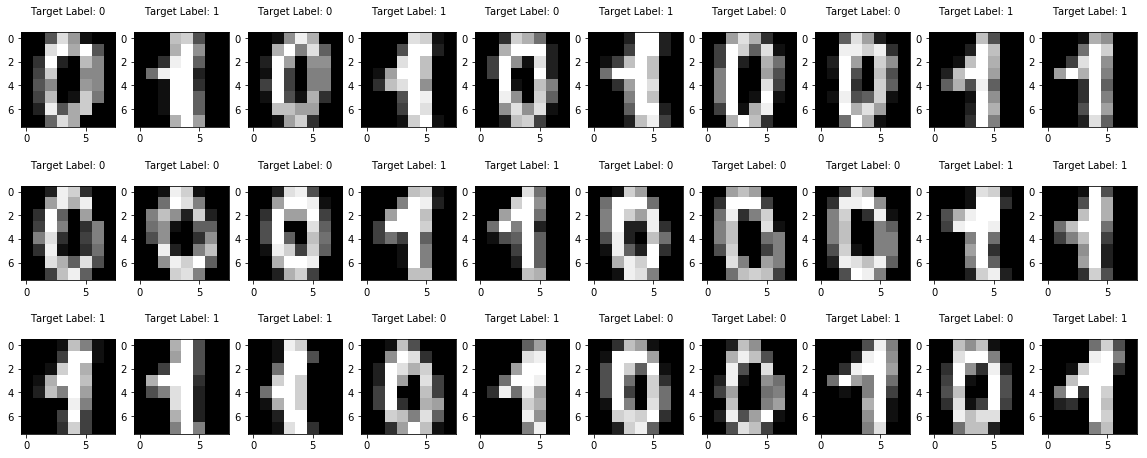

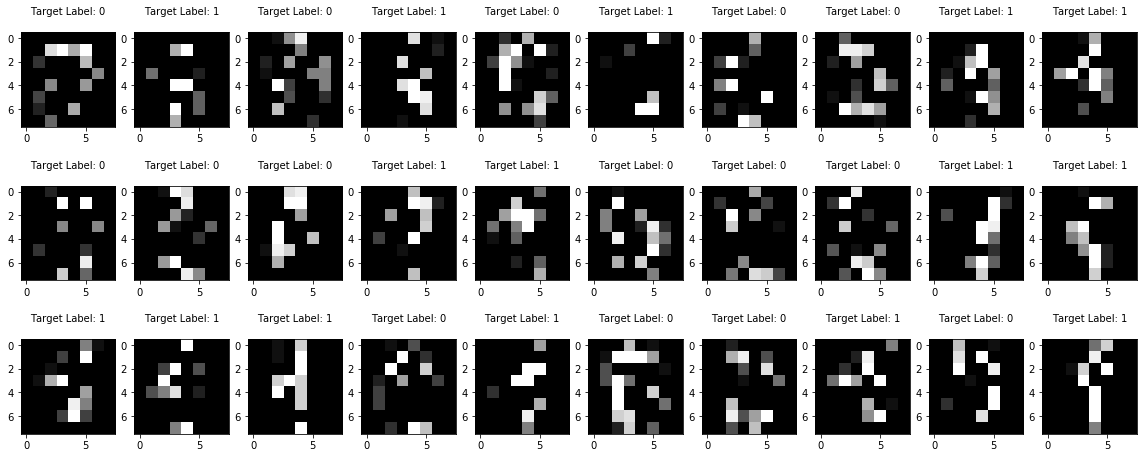

In [3]:
def show_some_digits(X, Y):

    # Here we just want to visualize some of the data points in the data set, along with their labels. 
    #
    # Create a large figure, to be filled with multiple subplots
    plt.figure(figsize=(20,8))
    # Go over the first 30 data points
    for index, (image, label) in enumerate(zip(X[0:30], Y[0:30])):
        plt.subplot(3, 10, index + 1)
        # Reshape the 64 features of each data point into an 8x8 image and then plot it.
        plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
        # Write the label of each point.
        plt.title('Target Label: %i\n' % label, fontsize = 10)
    return


# Here we create a noisy version of the data set
# The way that we do it is we go over all the pixels of
# each of the data points; then with probability p we multiply
# the value of that pixel by 0 (makring it essentially black).
# Otherwise (with probability 1-p) we multiply the value of that
# pixel by 1 (essentially keeping the pixel untouched)

# This the probability p of dropping a pixel (making it zero)
def make_it_noisy (X, drop_probability):
# This is how we create the noisy data set
    return np.multiply(X, np.random.choice([0, 1], size=(360,64), p=[drop_probability, 1 - drop_probability]))


print ("Hear are some of the original digits (first three rows)...and then their noisy versions")
show_some_digits(X, Y)
X_noisy = make_it_noisy (X, 0.6)
show_some_digits(X_noisy, Y)

print("len of X",len(X))
print("len of X_noisy",len(X_noisy))


In [4]:
# Here we define our own nearest neighbor classifier
# Any classifier should implement two main functions.
# The first one is fit() which takes the training data
# and does the training. The second one is predict()
# which is used after the training to predict the label
# of new points.
class MyNNClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param
        return

    # For the case of nearest neighbor , we don't really have any training;
    # we just need to store the training data points.
    def fit(self, X, Y):
        # Check that X and y have correct shape
        X, Y = check_X_y(X, Y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(Y)
        self.X_ = X
        self.Y_ = Y

        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'Y_'])
        # Input validation
        X = check_array(X)
        
        # This is the main step of NN which is finding the closest point in the training data
        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.Y_[closest]

In [5]:
# This is our soft-margin SVM classifer.
class MySoftSVMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param
        return

    def fit(self, X, Y):
        # Check that X and y have correct shape
        X, Y = check_X_y(X, Y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(Y)
        self.X_ = X
        self.Y_ = Y
        
        # We use Stochastic Gradient Descent (SGD) to train a soft-margin SVM
        # The loss function is therefore the hinge loss and
        # ... the regularizaiton term will be l2 (Euclidean)
        # The constant multiplied by the regulariztion term is alpha (in the class we used lambda)
        # max_iter is the maximum number of iterations for the optimization
        self.softSVM = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, alpha=.1)
        self.softSVM.fit(X, Y)

        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'Y_'])
        # Input validation
        X = check_array(X)
        
        return self.softSVM.predict(X)

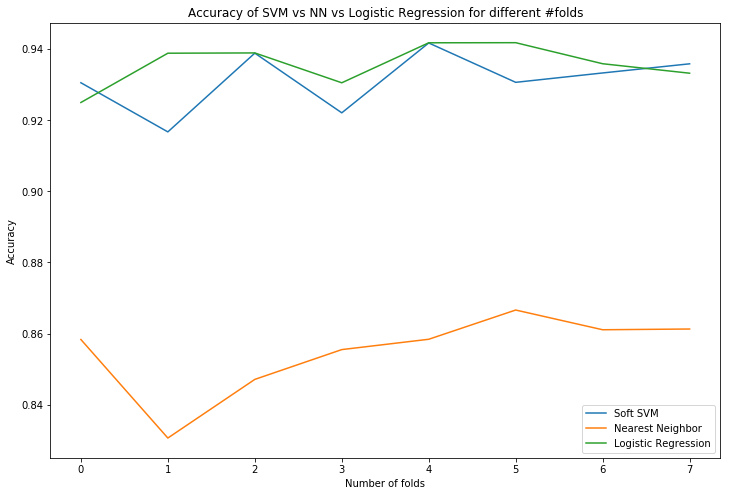

In [6]:
# We want to test the accuracy of SVM, Nearest Neighbor and
# ... Logistic Regression classifiers

# Our own NN classifier
NN = MyNNClassifier()
# Our own Soft SVM classifier
softSVM = MySoftSVMClassifier()
# Logistic Regression directly from scikit library
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

softSVM_scores_all = []
NN_scores_all = []
LR_scores_all = []


# We use cross-validation to determine the accuracy.
# In t-fold cross-validation, the data is divided into
# t subsets. One of the subsets is used for testing, and 
# the other t-1 subsets (folds) are used for training.
# The test score is then calculated. Now, we could have 
# selected the test subset to be one of the other folds;
# therefore, we can have t different possible ways of 
# computing the socres. We take the average of these t
# possible ways as a measure for accuracy of the method.

for t in range(2,10):
    softSVM_scores = cross_val_score(softSVM, X_noisy, Y, cv=t)
    softSVM_scores_all.append(softSVM_scores.mean())    
    NN_scores = cross_val_score(NN, X_noisy, Y, cv=t)
    NN_scores_all.append(NN_scores.mean())
    LR_scores = cross_val_score(LR, X_noisy, Y, cv=t)
    LR_scores_all.append(LR_scores.mean())

# Here we plot the cross-validation accuracy of NN and SVM 
# ... for different number of folds

plt.figure(figsize=(12,8))
plt.plot(softSVM_scores_all)
plt.plot(NN_scores_all)
plt.plot(LR_scores_all)
plt.legend(['Soft SVM', 'Nearest Neighbor', 'Logistic Regression'])
plt.title('Accuracy of SVM vs NN vs Logistic Regression for different #folds')
plt.xlabel('Number of folds')
plt.ylabel('Accuracy')

plt.show()
    


In [ ]:
def checkAccuracy(a,b):
    correct = 0;
    for i in range(len(a)):
#        print(i, " : ", a[i], "->", b[i])
        
        if(a[i] == b[i]):
            correct  += 1
#    print("num correct: ",correct)
#    print(len(a))
    return (correct/len(a))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#train_test_split is imported
X_train, X_test, y_train, y_test = train_test_split(X_noisy, Y, test_size=0.30, random_state=42)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in range(1,20,1):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

for i in cv_scores:
    print(i)

print("max accuracy", max(cv_scores))
print("at k", cv_scores.index(max(cv_scores)) )

In [ ]:
from collections import Counter

# Here we define our own nearest neighbor classifier
# Any classifier should implement two main functions.
# The first one is fit() which takes the training data
# and does the training. The second one is predict()
# which is used after the training to predict the label
# of new points.
class MyKNNClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param
        return

    # For the case of nearest neighbor , we don't really have any training;
    # we just need to store the training data points.
    def fit(self, X, Y):
        # Check that X and y have correct shape
        X, Y = check_X_y(X, Y)
        
        xTrain, xTest, yTrain, yTest = train_test_split(X,Y, test_size=0.30, random_state=42)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(Y)
        
        self.xTrain_ = xTrain
        self.yTrain_ = yTrain
        self.xTest_ = xTest
        self.yTest_ = yTest
        self.foundK_ = findK(X,Y)
        
        # Return the classifier
        return self
    
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['xTrain_', 'yTrain_'])

        predictions = []
        # loop over all observations
        for i in range(len(X)):
#            print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")

#            print("testing:->", X[i,:])
            output = predicthelper(self.xTrain_, self.yTrain_, X[i, :], self.foundK_)
#            print("output is - >", output)
#            print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            predictions.append(output)
        return predictions
        
def findK(xGiven, yGiven):
    xTrain, xTest, yTrain, yTest = train_test_split(xGiven, yGiven, test_size=0.30, random_state=42)

    results = []

    for i in range(1,20,2):
        score = []
        score = findKHelper(xTrain, yTrain, xTest, yTest, i)
        score = np.asarray(score)
        accuracy = checkAccuracy(yTest, score)
        results.append(accuracy)

#    print(results)
#    print("max accuracy", max(results))
    foundK = results.index(max(results))*2+1
#    print("at k", foundK)
    return foundK

def findKHelper(xTrain, yTrain, xTest, yTest,k):
    predictions = []
    # loop over all observations
    for i in range(len(xTest)):
        output = predicthelper(xTrain, yTrain, xTest[i, :], k)
        predictions.append(output)
    return predictions


def predicthelper(X_train, y_train, x_test, k):
    # create list for distances and targets
    distances = []
    targets = []

    for i in range(len(X_train)):
        # first we compute the euclidean distance
        distance = np.sqrt(np.sum(np.square(x_test - X_train[i, :])))
        # add it to list of distances
        distances.append([distance, i])

    # sort the list
    distances = sorted(distances)

    # make a list of the k neighbors' targets
    for i in range(k):
        index = distances[i][1]
        targets.append(y_train[index])

    # return most common target
    return Counter(targets).most_common(1)[0][0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy, Y, test_size=0.30, random_state=42)

knn = MyKNNClassifier()
knn.fit(X_noisy, Y)
print(knn.foundK_)

In [2]:
# We want to test the accuracy of SVM, Nearest Neighbor and
# Logistic Regression classifiers

# Our own NN classifier
NN = MyNNClassifier()
KNN = MyKNNClassifier()
# Our own Soft SVM classifier
softSVM = MySoftSVMClassifier()
# Logistic Regression directly from scikit library
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')


softSVM_scores_all = []
NN_scores_all = []
LR_scores_all = []
sall=[]

# We use cross-validation to determine the accuracy.
# In t-fold cross-validation, the data is divided into
# t subsets. One of the subsets is used for testing, and 
# the other t-1 subsets (folds) are used for training.
# The test score is then calculated. Now, we could have 
# selected the test subset to be one of the other folds;
# therefore, we can have t different possible ways of 
# computing the socres. We take the average of these t
# possible ways as a measure for accuracy of the method.
for t in range(2,10):
    
    softSVM_scores = cross_val_score(softSVM, X_noisy, Y, cv=t)
    softSVM_scores_all.append(softSVM_scores.mean())    
    
    NN_scores = cross_val_score(NN, X_noisy, Y, cv=t)
    NN_scores_all.append(NN_scores.mean())    
    
    ss = cross_val_score(KNN, X_noisy, Y, cv=t)
    sall.append(ss.mean())
    
    LR_scores = cross_val_score(LR, X_noisy, Y, cv=t)
    LR_scores_all.append(LR_scores.mean())
    


# Here we plot the cross-validation accuracy of NN and SVM 
# ... for different number of folds

plt.figure(figsize=(12,8))

plt.plot(softSVM_scores_all)
plt.plot(NN_scores_all)
plt.plot(LR_scores_all)
plt.plot(sall)

plt.legend(['Soft SVM', 'Nearest Neighbor', 'Logistic Regression', 'KNN'])
plt.title('Accuracy of SVM vs NN vs Logistic Regression for different #folds')
plt.xlabel('Number of folds')
plt.ylabel('Accuracy')

plt.show()

NameError: name 'MyNNClassifier' is not defined